In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import nd, autograd, gluon, optimizer
from mxnet.image import color_normalize
mx.random.seed(1)

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
mx.__version__

'1.1.0'

## Set the context

In [3]:
ctx = mx.gpu()

## Load our data

In [4]:
#Binary Classifier
num_outputs = 1
batch_size = 64

train_data = mx.io.ImageRecordIter(path_imgrec='lego_train.rec',
                                   min_img_size=512,
                                   data_shape=(3, 512, 512),
                                   rand_crop=False,
                                   shuffle=True,
                                   batch_size=batch_size,
                                   max_rotation=15,
                                   rand_mirror=True)

test_data = mx.io.ImageRecordIter(path_imgrec='lego_val.rec',
                                 min_img_size=512,
                                 data_shape=(3, 512, 512),
                                 batch_size=batch_size)

train_data.reset()
test_data.reset()


(64, 3, 512, 512)


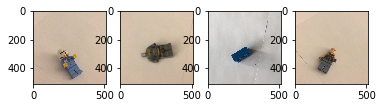

In [5]:
batch = train_data.next()
data = batch.data[0]
print(data.shape)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))

## Define a convolutional neural network

Again, a few lines here is all we need in order to change the model. Let's add a couple of convolutional layers using gluon.nn.



In [8]:
net = gluon.nn.Sequential()
with net.name_scope():
    #  First convolutional layer
    net.add(gluon.nn.Conv2D(channels=96, kernel_size=11, strides=(4,4), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))    
    #  Second convolutional layer
    net.add(gluon.nn.Conv2D(channels=192, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=3, strides=(2,2)))            
    # Third convolutional layer
    net.add(gluon.nn.Conv2D(channels=384, kernel_size=3, activation='relu'))
    # Fourth convolutional layer
    net.add(gluon.nn.Conv2D(channels=384, kernel_size=3, activation='relu')) 
    # Fifth convolutional layer
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))    
    # Flatten and apply fullly connected layers
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(4096, activation="relu"))
    net.add(gluon.nn.Dense(4096, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs, activation="sigmoid"))

## Parameter Initialization

In [9]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

## Loss Function

In [10]:
sigmoid_binary_cross_entropy = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
logisitc_loss = gluon.loss.LogisticLoss(label_format='binary')

## Optimizer

In [11]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})

## Accuracy Evaluation

In [12]:
metric = mx.metric.create(['rmse'])

def evaluate(net, data_iter, ctx):
    data_iter.reset()
    for batch in data_iter:
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        for x in data:
            outputs.append(net(x))
        metric.update(label, outputs)
    out = metric.get()
    metric.reset()
    return out


## Training Loop

In [20]:
epochs = 100
smoothing_constant = .01
moving_loss = 0

train_data.reset()

for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(nd.array(batch.data[0]), ctx_list=[ctx])
        label = gluon.utils.split_and_load(nd.array(batch.label[0]), ctx_list=[ctx])
        
        with autograd.record():
            for x, y in zip(data, label):
                output = net(x)
                loss = sigmoid_binary_cross_entropy(output, y)
        loss.backward()
        trainer.step(64)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)
        
    test_accuracy = evaluate(net, test_data, [ctx])
    train_accuracy = evaluate(net, train_data, [ctx])
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

Epoch 0. Loss: 0.580918911256, Train_acc (['rmse'], [0.42144489785035449]), Test_acc (['rmse'], [0.41794427235921222])
Epoch 1. Loss: 0.576175629377, Train_acc (['rmse'], [0.41019883480938996]), Test_acc (['rmse'], [0.41137403249740601])
Epoch 2. Loss: 0.575021834991, Train_acc (['rmse'], [0.40374030669530231]), Test_acc (['rmse'], [0.40419949591159821])
Epoch 3. Loss: 0.578539769923, Train_acc (['rmse'], [0.42422433694203693]), Test_acc (['rmse'], [0.42218676209449768])
Epoch 4. Loss: 0.575516758984, Train_acc (['rmse'], [0.40813094625870389]), Test_acc (['rmse'], [0.40027971565723419])
Epoch 5. Loss: 0.579614806115, Train_acc (['rmse'], [0.43584438661734265]), Test_acc (['rmse'], [0.43872888386249542])
Epoch 6. Loss: 0.577225116914, Train_acc (['rmse'], [0.39822434837167914]), Test_acc (['rmse'], [0.39653606712818146])
Epoch 7. Loss: 0.573872231666, Train_acc (['rmse'], [0.39976125707228977]), Test_acc (['rmse'], [0.39593788981437683])
Epoch 8. Loss: 0.565586068093, Train_acc (['rmse

Epoch 69. Loss: 0.352914786504, Train_acc (['rmse'], [0.27225155880053836]), Test_acc (['rmse'], [0.27515783905982971])
Epoch 70. Loss: 0.342768774386, Train_acc (['rmse'], [0.25660183890299365]), Test_acc (['rmse'], [0.26389692723751068])
Epoch 71. Loss: 0.333448346413, Train_acc (['rmse'], [0.25321094443400699]), Test_acc (['rmse'], [0.25900314748287201])
Epoch 72. Loss: 0.325051527866, Train_acc (['rmse'], [0.25582859665155411]), Test_acc (['rmse'], [0.2620786726474762])
Epoch 73. Loss: 0.316700306559, Train_acc (['rmse'], [0.25582509984572727]), Test_acc (['rmse'], [0.26167368143796921])
Epoch 74. Loss: 0.309891763791, Train_acc (['rmse'], [0.24907194947203001]), Test_acc (['rmse'], [0.25743772089481354])
Epoch 75. Loss: 0.324305592431, Train_acc (['rmse'], [0.2530610520731319]), Test_acc (['rmse'], [0.26167920231819153])
Epoch 76. Loss: 0.315074280349, Train_acc (['rmse'], [0.24534559498230615]), Test_acc (['rmse'], [0.25364097207784653])
Epoch 77. Loss: 0.307903808828, Train_acc 

## Time to Test!

In [31]:
import cv2

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (512, 512))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

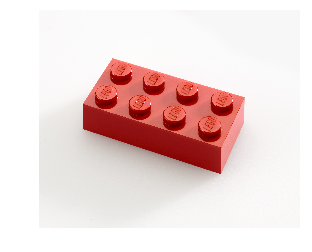

In [40]:
brick = get_image('https://27gen.files.wordpress.com/2013/06/lego-red-brick.jpg', True)

In [41]:
with mx.Context(ctx):
    print(net(nd.array(brick)))


[[ 0.32043365]]
<NDArray 1x1 @gpu(0)>


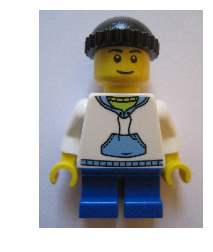

In [42]:
minifigure = get_image('https://i.ebayimg.com/images/g/cOQAAOxyA9dSZp5~/s-l1600.jpg', True)

In [43]:
with mx.Context(ctx):
    print(net(nd.array(minifigure)))


[[ 0.70227444]]
<NDArray 1x1 @gpu(0)>
